<a href="https://colab.research.google.com/github/jakubsroba/MIP_/blob/main/ai_job_market_insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

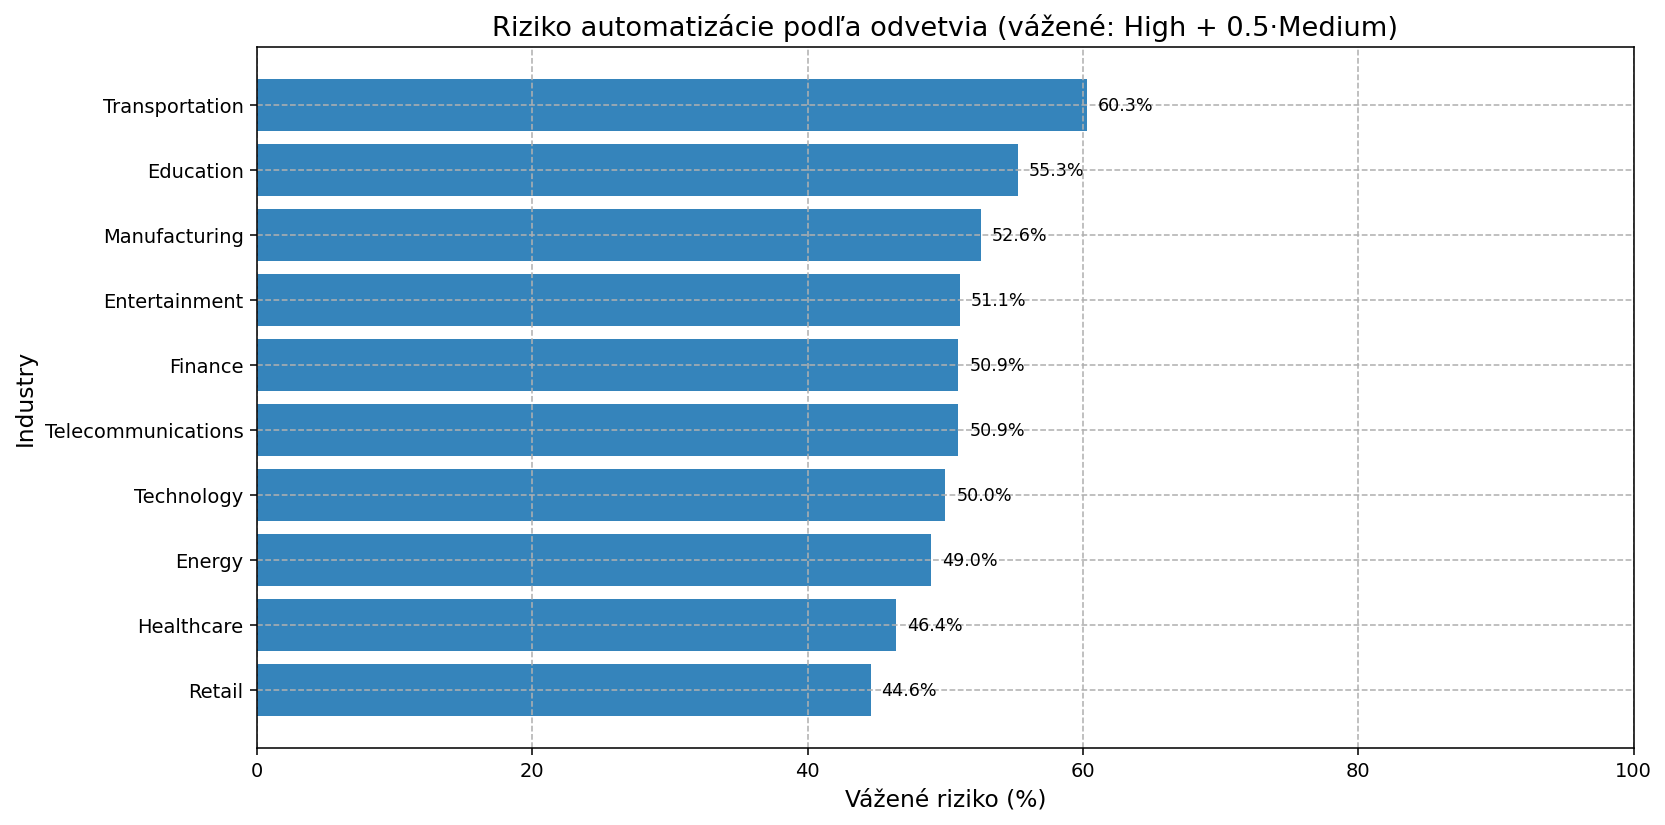

⬇️ Sťahujem: industry_weighted_automation_risk_rank.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


SCRIPT (stručne):
- Zoradený rebríček odvetví podľa váženého rizika: (High + 0.5·Medium) / (Low+Medium+High) · 100.
- Low je v menovateli, preto odvetvia s veľa 'Low' prirodzene pôsobia bezpečnejšie.
- Percentá pri každom stĺpci ukazujú odhadovanú mieru rizika automatizácie pre dané odvetvie.



In [17]:
# ai_job_market_insights.ipynb
# Industry rebríček podľa váženého rizika: (High + 0.5*Medium) / (Low+Medium+High) * 100
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Colab download detekcia ---
IN_COLAB = False
try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# --- Parametre ---
CSV_PATH = Path("/content/ai_job_market_insights.csv")
MIN_SUPPORT = 10     # minimálny počet ponúk v odvetví (filter šumu)
WEIGHT_MEDIUM = 0.5  # váha "Medium" pri výpočte rizika

plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.grid": True,
    "grid.linestyle": "--",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "figure.dpi": 140
})

def _norm_risk(x):
    """Zjednotí rôzne zápisy rizika na Low/Medium/High."""
    s = str(x).strip().lower()
    if s in {"high","h","3"}:   return "High"
    if s in {"medium","med","m","2"}: return "Medium"
    if s in {"low","l","1"}:    return "Low"
    return np.nan

def _label(v):
    """Ak by Industry bol tuple/MultiIndex, spraví čitateľný text."""
    return " / ".join(map(str, v)) if isinstance(v, tuple) else str(v)

# 1) Načítanie
if not CSV_PATH.exists():
    if IN_COLAB:
        print("➡️ Nahraj súbor ai_job_market_insights.csv")
        up = files.upload()
        CSV_PATH = Path("/content") / list(up.keys())[0]
    else:
        raise FileNotFoundError(f"CSV súbor neexistuje: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)

# 2) Normalizácia
need = {"Industry", "Automation_Risk"}
if not need.issubset(df.columns):
    raise ValueError(f"Dataset musí obsahovať stĺpce: {need}")

for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].astype(str).str.strip()

df["Automation_Risk_norm"] = df["Automation_Risk"].apply(_norm_risk)

# 3) Kontingenčná tabuľka (Industry x riziko) + filter
tab = (df.groupby(["Industry", "Automation_Risk_norm"])
         .size()
         .unstack(fill_value=0))

for col in ["Low","Medium","High"]:
    if col not in tab.columns:
        tab[col] = 0

tab["Total"] = tab[["Low","Medium","High"]].sum(axis=1)
tab = tab[tab["Total"] >= MIN_SUPPORT]

# 4) Vážené skóre: (High + 0.5*Medium) / Total * 100
tab["Weighted_Risk_%"] = np.where(
    tab["Total"] > 0,
    (tab["High"] + WEIGHT_MEDIUM * tab["Medium"]) / tab["Total"] * 100.0,
    0.0
)

# 5) Zoradenie (najrizikovejšie hore; pri remíze viac ponúk vyššie)
tab_sorted = tab.sort_values(by=["Weighted_Risk_%","Total"], ascending=[False, False])

# 6) Graf – iba percentá v popiskoch
industries = [_label(ix) for ix in tab_sorted.index]
vals = tab_sorted["Weighted_Risk_%"].values

fig_h = max(6, 0.45 * len(industries))
plt.figure(figsize=(12, fig_h))
plt.barh(industries, vals, alpha=0.9)

plt.title(f"Riziko automatizácie podľa odvetvia (vážené: High + {WEIGHT_MEDIUM}·Medium)")
plt.xlabel("Vážené riziko (%)")
plt.ylabel("Industry")
plt.xlim(0, max(100, min(120, vals.max()*1.15)))

# popisky: iba percentá
for y, v in enumerate(vals):
    plt.text(v + 0.8, y, f"{v:.1f}%", va="center", fontsize=9)

plt.gca().invert_yaxis()  # najvyššie riziko hore
plt.tight_layout()
out_path = "industry_weighted_automation_risk_rank.png"
plt.savefig(out_path, bbox_inches="tight")
plt.show()

if IN_COLAB:
    print(f"⬇️ Sťahujem: {out_path}")
    files.download(out_path)

print(f"""
SCRIPT (stručne):
- Zoradený rebríček odvetví podľa váženého rizika: (High + {WEIGHT_MEDIUM}·Medium) / (Low+Medium+High) · 100.
- Low je v menovateli, preto odvetvia s veľa 'Low' prirodzene pôsobia bezpečnejšie.
- Percentá pri každom stĺpci ukazujú odhadovanú mieru rizika automatizácie pre dané odvetvie.
""")
